# Load python packages for data handling and plotting

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
mpl.rcParams['image.cmap'] = 'hot_r' # change default color map

%matplotlib inline

Uproot package for ROOT > numpy data conversion: https://github.com/scikit-hep/uproot

In [2]:
import uproot
import uproot._connect.to_pandas # load the pandas connection

Load some statistics function

In [3]:
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic#, binned_statistic_2d
from scipy.special import erf
from scipy.stats import iqr
from scipy.stats import norm

Increase default font size

In [4]:
font = {'size'   : 16}
mpl.rc('font', **font)

## Load input data

In [5]:
file_name = "https://alobanov.web.cern.ch/alobanov/public/HGCAL_TBOct2018_ntuple_run_925.root"
file_content = uproot.open(file_name)

Inspect file content (ROOT TTrees)

In [6]:
file_content.allkeys()

['rechitntupler;1',
 'rechitntupler/hits;6',
 'rechitntupler/hits;5',
 'trackimpactntupler;1',
 'trackimpactntupler/impactPoints;1',
 'XCETntupler;1',
 'XCETntupler/XCET;1',
 'MCPntupler;1',
 'MCPntupler/MCP;1']

Look into HGCAL hit collection

In [7]:
hits = file_content["rechitntupler/hits"]

List branches

In [8]:
print(hits.keys())

['event', 'trigger_timestamp', 'run', 'pdgID', 'beamEnergy', 'trueBeamEnergy', 'NRechits', 'rechit_detid', 'rechit_module', 'rechit_layer', 'rechit_chip', 'rechit_channel', 'rechit_type', 'rechit_x', 'rechit_y', 'rechit_z', 'rechit_iu', 'rechit_iv', 'rechit_iU', 'rechit_iV', 'rechit_energy', 'rechit_energy_noHG', 'rechit_amplitudeHigh', 'rechit_amplitudeLow', 'rechit_hg_goodFit', 'rechit_lg_goodFit', 'rechit_hg_saturated', 'rechit_lg_saturated', 'rechit_fully_calibrated', 'rechit_noise_flag', 'rechit_TS2High', 'rechit_TS2Low', 'rechit_TS3High', 'rechit_TS3Low', 'rechit_Tot', 'rechit_toa_calib_flag', 'rechit_toaFall_flag', 'rechit_toaRise_flag', 'rechit_toaFall_norm', 'rechit_toaRise_norm', 'rechit_toaFall_time', 'rechit_toaRise_time', 'rechit_toaFall_corr_time', 'rechit_toaRise_corr_time', 'rechit_calib_time_toaFall', 'rechit_calib_time_toaRise', 'rechit_toaRise', 'rechit_toaFall', 'rechit_timeMaxHG', 'rechit_timeMaxLG']


Inspect event branch (for first 10 events)

In [9]:
hits.array('event', entrystop = 10)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint32)

Inspect number of rechits per event

In [10]:
hits.array('NRechits', entrystop = 10)

array([946, 894, 956, 955, 931, 936, 909, 983, 920, 941], dtype=uint32)

In [11]:
hits.array('rechit_energy', entrystop = 10)

<JaggedArray [[4.062109470367432 34.0714111328125 11.07606315612793 ... 0.3786887228488922 0.7171839475631714 0.338591605424881] [1.741884469985962 63.24577331542969 0.5645696520805359 ... 0.4616595208644867 0.757352888584137 0.7396867871284485] [1.1983237266540527 3.3835232257843018 25.12059211730957 ... 0.5604773759841919 0.9161921739578247 0.44372689723968506] ... [1.3993617296218872 5.016274452209473 39.39462661743164 ... 2.647599458694458 0.3892793655395508 0.4487347900867462] [10.583016395568848 7.866400241851807 10.396089553833008 ... 0.2879127562046051 0.8451618552207947 0.3566696047782898] [3.6306283473968506 13.055957794189453 1.149782657623291 ... 0.37399154901504517 0.41563186049461365 0.41283759474754333]] at 0x00010baf7550>

### Dump data into pandas dataframe

In [12]:
# Select branches
branches = ['event', 'run',
            'rechit_layer', 'rechit_x', 'rechit_y', 'rechit_z',
            'rechit_noise_flag','rechit_energy']

In [13]:
df_hits = hits.pandas.df(branches, entrystop = 100, flatten = False)

Check info of loaded dataframe

In [14]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
event                100 non-null uint32
run                  100 non-null uint32
rechit_layer         100 non-null object
rechit_x             100 non-null object
rechit_y             100 non-null object
rechit_z             100 non-null object
rechit_noise_flag    100 non-null object
rechit_energy        100 non-null object
dtypes: object(6), uint32(2)
memory usage: 5.5+ KB


In [15]:
df_hits.memory_usage()

Index                 72
event                400
run                  400
rechit_layer         800
rechit_x             800
rechit_y             800
rechit_z             800
rechit_noise_flag    800
rechit_energy        800
dtype: int64

Look at first 5 entries (rows) of dataframe

In [16]:
df_hits.head()

,event,run,rechit_layer,rechit_x,rechit_y,rechit_z,rechit_noise_flag,rechit_energy
0,1,925,"[1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, ...","[-8.996576e-06, -0.9744873, -1.9489746, -0.974...","[2.2504883, 1.6877441, 2.2504883, 1.6877441, 2...","[13.32, 13.32, 13.32, 14.21, 14.21, 14.21, 14....","[False, False, False, False, False, False, Fal...","[4.0621095, 34.07141, 11.076063, 62.524364, 3...."
1,2,925,"[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[-9.002164e-06, -0.9744873, -0.9744873, -1.948...","[-1.1252441, 1.6877441, 0.5626221, 1.1252441, ...","[13.32, 13.32, 13.32, 13.32, 13.32, 13.32, 14....","[False, False, False, False, False, False, Fal...","[1.7418845, 63.245773, 0.56456965, 3.1437073, ..."
2,3,925,"[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, ...","[-0.9744873, -1.9489746, -1.9489746, -2.923339...","[1.6877441, 2.2504883, 1.1252441, 2.8129883, 1...","[13.32, 13.32, 13.32, 13.32, 13.32, 13.32, 13....","[False, False, False, False, False, False, Fal...","[1.1983237, 3.3835232, 25.120592, 2.3140147, 3..."
3,4,925,"[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, ...","[-9.004027e-06, -0.9744873, -0.9744873, -0.974...","[-2.2504883, -0.5626221, 1.6877441, 0.5626221,...","[13.32, 13.32, 13.32, 13.32, 13.32, 13.32, 13....","[False, False, False, False, False, False, Fal...","[0.95969886, 0.73515594, 56.524765, 1.7035829,..."
4,5,925,"[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, ...","[-8.996576e-06, -8.998439e-06, -0.9744873, -0....","[2.2504883, 1.1252441, -0.5626221, 1.6877441, ...","[13.32, 13.32, 13.32, 13.32, 13.32, 13.32, 13....","[False, False, False, False, False, False, Fal...","[1.3940479, 52.03309, 1.0694722, 1.3659339, 1...."


In [17]:
for event_id in df_hits.index[:10]:
    print(df_hits.iloc[event_id]['event'])

1
2
3
4
5
6
7
8
9
10


In [18]:
e_sums = []
for event_id in df_hits.index:
     e_sums.append(df_hits.iloc[event_id]['rechit_energy'].sum())

In [19]:
e_sums[:5]

[14733.342, 14277.979, 14161.652, 14396.922, 14590.366]

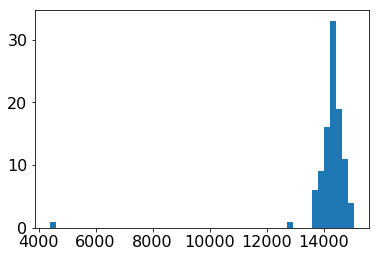

In [20]:
ret = plt.hist(e_sums, 50)

Select energies above median/2

In [21]:
e_sums = np.array(e_sums) # convert to numpy array for easier handling

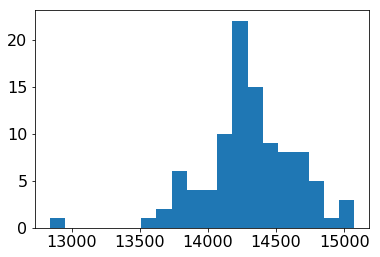

In [22]:
# create mask
sel = e_sums > np.median(e_sums)/2.

# apply mask: 
x = e_sums[sel]
ret = plt.hist(x, 20)

### Flatten array

Flatten means: one 'hit' per row

In [23]:
%%time
df_hits = hits.pandas.df(branches, entrystop = 100, flatten = True)

CPU times: user 58 ms, sys: 5.45 ms, total: 63.4 ms
Wall time: 69.9 ms


The size of the DF increases due to the different handling of the data

In [24]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 95146 entries, (0, 0) to (99, 924)
Data columns (total 8 columns):
event                95146 non-null uint32
run                  95146 non-null uint32
rechit_layer         95146 non-null uint32
rechit_x             95146 non-null float32
rechit_y             95146 non-null float32
rechit_z             95146 non-null float32
rechit_noise_flag    95146 non-null bool
rechit_energy        95146 non-null float32
dtypes: bool(1), float32(4), uint32(3)
memory usage: 2.9 MB


In [25]:
df_hits.head()

event  run  rechit_layer  rechit_x  rechit_y  rechit_z  \
entry subentry                                                           
0     0             1  925             1 -0.000009  2.250488     13.32   
      1             1  925             1 -0.974487  1.687744     13.32   
      2             1  925             1 -1.948975  2.250488     13.32   
      3             1  925             2 -0.974487  1.687744     14.21   
      4             1  925             2 -1.948975  2.250488     14.21   

                rechit_noise_flag  rechit_energy  
entry subentry                                    
0     0                     False       4.062109  
      1                     False      34.071411  
      2                     False      11.076063  
      3                     False      62.524364  
      4                     False       3.603892

In [26]:
e_sums_df = df_hits.groupby('event')['rechit_energy'].sum()

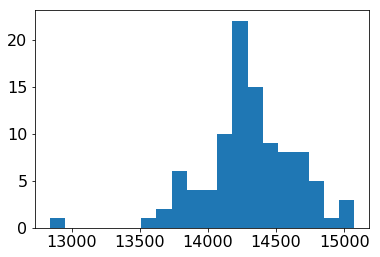

In [27]:
sel = e_sums_df > e_sums_df.median()/2.
r = plt.hist(e_sums_df[sel], 20)